# Examples

Here is a short guide to using carspy in a project:

## Setup

### Import necessary modules

In [2]:
from carspy import CarsSpectrum

### Additional modules

`numpy` and `matplotlib` are also used in this demo.

In [12]:
import numpy as np
import matplotlib.pyplot as plt


## Synthesize CARS spectra

### Initialize the parameters

Following is the standard procedure to start syntheiszing a spectrum. By default, the set of nonresonant susceptibilities used is taken from CARSFT \[[Pal89](references)\] ("Set 1"). Details regarding the choices can be found in the [module documentation](cars_synth). Custom values can be used by modifying the following attributes:
 
- `.chi_nrs` (a dictionary of species names and nonresonant susceptiblities),
- `.chi_nrs_T0` (standard temperature for the susceptibilities),
- `.chi_nrs_P0` (standard pressure for the susceptibilities) 

In [5]:
# set the modes used to generate the spectrum
synth_mode = {'pump_ls': 'Gaussian',  # pump laser lineshape
              'chi_rs': 'G-matrix',   # solve G-matrix
              'convol': 'Kataoka',    # Kataoka convolution (convolve twice)
              'doppler_effect': True, # convolution with Doppler broadening
              'chem_eq': False}       # Not assume chemical equilibrium

# (optional) initial gas composition
init_comp = {'N2': 0.79,
             'Ar': 0.0,
             'CO2': 0,
             'CO': 0,
             'H2': 0,
             'O2': 0.21,
             'H2O': 0,
             'CH4': 0}

# initialize the spectrum
cars = CarsSpectrum(pressure=1, 
                    init_comp=init_comp,
                    chi_set="SET 1")


### Create the spectrum

Try varying the temperature and other parameters to see the changes in the CARS spectrum.


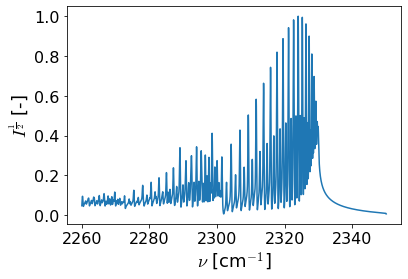

In [13]:
# define the spectral range
nu = np.linspace(2260, 2350, num=10000)
_, spect = cars.signal_as(temperature=1750,
                          nu_s=nu,
                          synth_mode=synth_mode,
                          pump_lw=0.2)

_, ax = plt.subplots(1)
ax.plot(nu, spect**0.5/spect.max()**0.5)
ax.set_ylabel(r'$I^{\frac{1}{2}}$ [-]')
ax.set_xlabel(r'$\nu$ [cm$^{-1}$]')
plt.show()